In [ ]:
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm

import utils
import filters
import modules

importlib.reload(utils)
importlib.reload(filters)
importlib.reload(modules)


<module 'modules' from '/Users/mark/Desktop/auditory_model_tutorial/modules.py'>

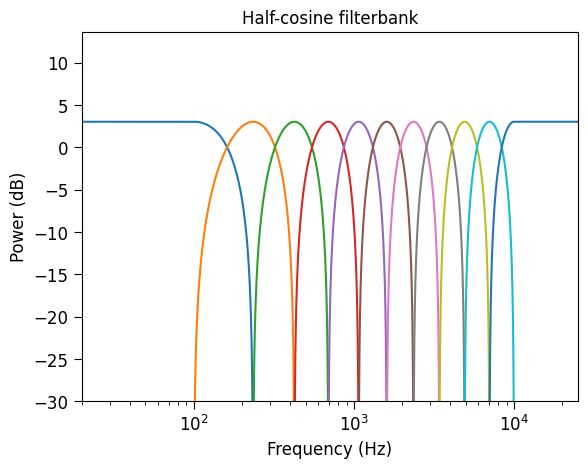

In [23]:
sr = 50000
filterbank = modules.HalfCosineFilterbank(
    sr=50000,
    cf_low=1e2,
    cf_high=1e4,
    cf_num=11,
    scale="erb",
    include_highpass=True,
    include_lowpass=True,
)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()

fig, ax = plt.subplots()
for i in range(impulse_response.shape[0]):
    fxx, pxx = utils.power_spectrum(impulse_response[i], sr=sr)
    ax.plot(fxx, pxx)
utils.format_axes(
    ax,
    str_title="Half-cosine filterbank",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB)",
    xscale="log",
    yscale="linear",
    xlimits=[20, sr / 2],
    ylimits=[-30, None],
)
plt.show()


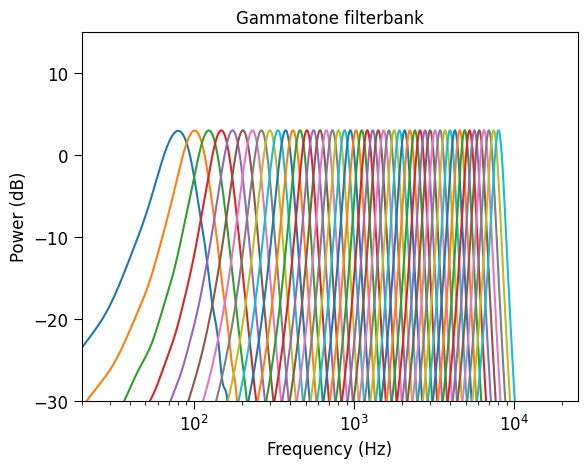

In [28]:
sr = 50000
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,
    cfs=utils.erbspace(8e1, 8e3, 50),
    dtype=torch.float32,
    bw_mult=1,
)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()

fig, ax = plt.subplots()
for i in range(impulse_response.shape[0]):
    fxx, pxx = utils.power_spectrum(impulse_response[i], sr=sr)
    ax.plot(fxx, pxx)
utils.format_axes(
    ax,
    str_title="Gammatone filterbank",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB)",
    xscale="log",
    yscale="linear",
    xlimits=[20, sr / 2],
    ylimits=[-30, None],
)
plt.show()


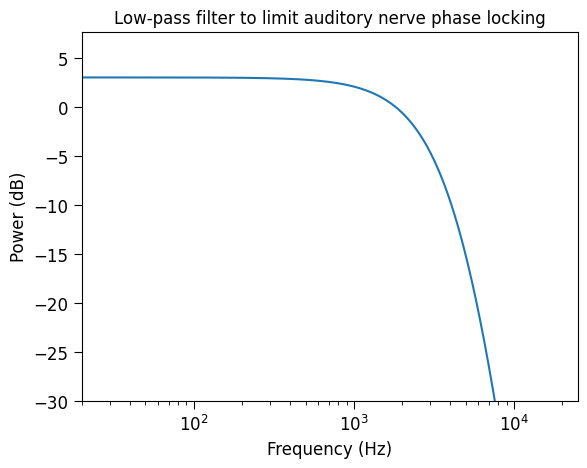

In [35]:
sr = 50000
filterbank = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.power_spectrum(impulse_response, sr=sr)
ax.plot(fxx, pxx)
utils.format_axes(
    ax,
    str_title="Low-pass filter to limit auditory nerve phase locking",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB)",
    xscale="log",
    yscale="linear",
    xlimits=[20, sr / 2],
    ylimits=[-30, None],
)
plt.show()


In [ ]:
class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=50000,
        sr_output=10000,
        fir_dur=0.05,
        compression_power=0.3,
    ):
        """
        Simple cochlear model.

        Args
        ----
        sr_input (int):
            Sampling rate of the input sound waveform.
        sr_output (int):
            Sampling rate of the output representation.
        fir_dur (float):
            Duration of the filter FIRs in seconds.
        compression_power (float):
            Power of the compression applied to filterbank outputs.
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=fir_dur,
            cfs=utils.erbspace(8e1, 8e3, 50),
            dtype=torch.float32,
            bw_mult=1,
        )
        self.compression_power = compression_power
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=fir_dur,
            cutoff=3e3,
            order=7,
        )

    def forward(self, x):
        """
        Run the cochlear model on an input sound waveform.

        Args
        ----
        x (torch.Tensor):
            Input sound waveform. Shape (batch_size, num_samples).

        Returns
        -------
        x (torch.Tensor):
            Output of the cochlear model. Shape (batch_size, frequency_channels, num_samples).
        """
        x = self.cochlear_filterbank(x)
        x = torch.nn.functional.relu(x)
        x = torch.pow(x, self.compression_power)
        x = self.ihc_lowpass_filter(x)
        x = torch.nn.functional.relu(x)
        return x


cochlear_model = CochlearModel()
sr = cochlear_model.sr_input

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse).float().unsqueeze(0)
impulse_response_tensor = cochlear_model(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
impulse_response.shape


(50, 10000)

In [40]:
for _ in tqdm.tqdm(range(10)):
    impulse_response_tensor = cochlear_model(impulse_tensor).squeeze(0)


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]
